# Exploratory Data Analysis (Using the Twitter_Influencers/Tweets.JSON files) 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec                                   #For Word2Vec
warnings.filterwarnings('ignore')

pd.set_option('mode.chained_assignment', None)

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

# Create URL to JSON file (alternatively this can be a filepath)
# Load the first sheet of the JSON file into a data frame
df = pd.read_json(r'C:\Users\USER\Downloads\datasets\twitter_influencers.json', orient='columns')
df_tweets = pd.read_json(r'C:\Users\USER\Downloads\datasets\tweets.json', orient='columns')
df_facebook = pd.read_json(r'C:\Users\USER\Downloads\datasets\tweets.json', orient='columns')
# View the first ten rows
df.head(10)

df['social_referrals'].to_csv(r'C:\Users\USER\Downloads\datasets\article_id.csv')

ModuleNotFoundError: No module named 'gensim'

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16655 entries, 0 to 16654
Data columns (total 8 columns):
followers_count      12489 non-null object
following_count      16655 non-null int64
likes_count          16655 non-null int64
max_retweet_value    16655 non-null int64
social_referrals     16655 non-null object
statuses_count       16655 non-null int64
twitter_handle       16655 non-null object
twitter_id           16655 non-null int64
dtypes: int64(5), object(3)
memory usage: 1.0+ MB


This looks like a very clean dataset, with very little NA values. There are 5 numeric variables and 3 categorical variables. 

In [22]:
#Some basic pre-processing:
# df.count() does not include NaN values

df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2


List of dropped columns: 



# Numerical Data Distribution

count    1.665500e+04
mean     9.318356e+05
std      3.649914e+06
min      0.000000e+00
25%      7.496000e+03
50%      6.315500e+04
75%      3.157360e+05
max      7.755958e+07
Name: followers_count, dtype: float64


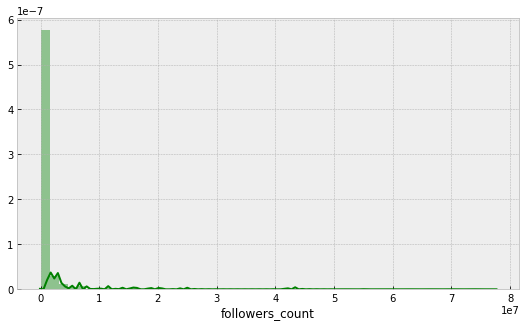

In [19]:
print(df['followers_count'].describe())
plt.figure(figsize=(9, 5))
sns.distplot(df['followers_count'], color='g', bins=50, hist_kws={'alpha': 0.4});


It looks like this data is skewed by individuals with very high follower counts. 
Let's try excluding them by creating a new dataframe with individuals that are NO greater than the 75th percentile, and by creating a log-transformation of the values. 

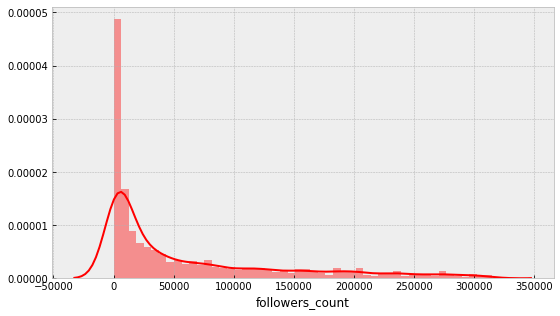

In [21]:

df2['followers_count'] = df[df['followers_count']< 3.157360e+05]
plt.figure(figsize=(9, 5))
sns.distplot(df2['followers_count'], color='r', bins=50, hist_kws={'alpha': 0.4});


For this part lets look at the distribution of all of the features by ploting them. To do so lets first list all the types of our data from our dataset and take only the numerical ones, and plot them using a histogram matrix. 

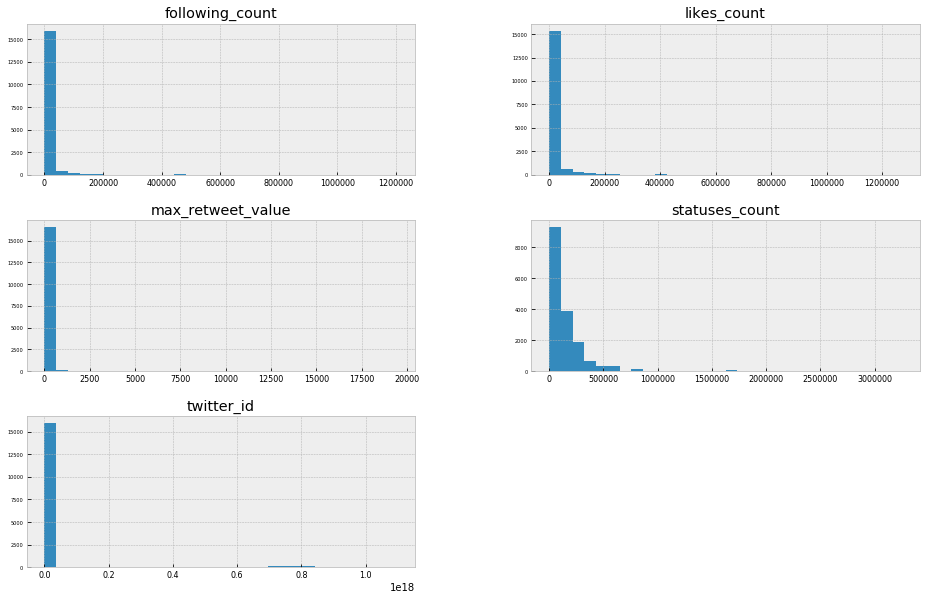

In [28]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 10), bins=30, xlabelsize=8, ylabelsize=5); # ; avoid having the matplotlib verbose informations


All of this data appears incredibly skewed. In the case of 'twitter_id', it acts more like a categorical variable. 
Let's inspect twitter id just to be very sure. 

In [47]:
df['twitter_id'].head()
del df_num['twitter_id']

This tells me this just shows the 'unique' twitter ids for each correlation, so we can assume to drop this/consider this 
as the **outcome** variable we are going to care about. 

# Log Transformation of Values

In [69]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y




# Correlation Matrix

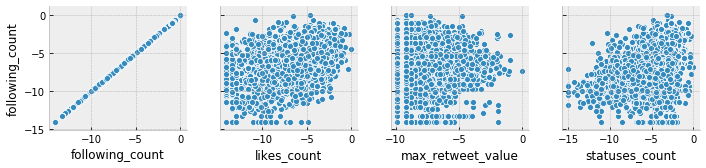

In [70]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['following_count'])


# Correlation Heatmap

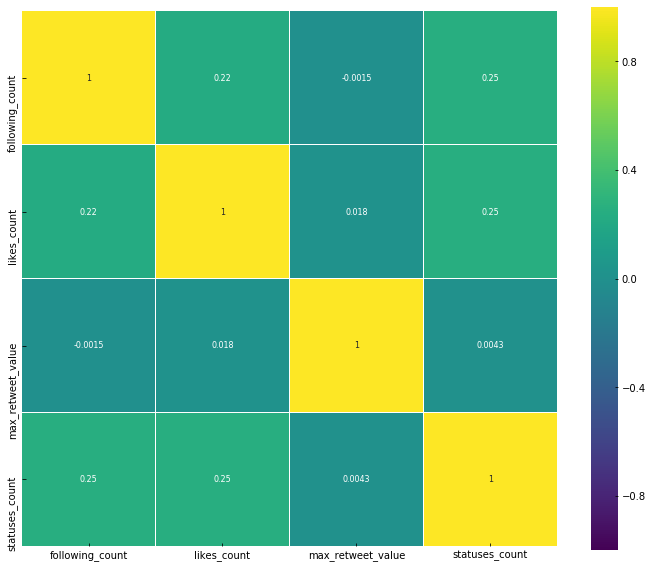

In [52]:
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.0001) | (corr <= -0.0001)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


# Cleaning the 'social_referrals' column

There are **five** key pieces of information that is relevant to the analysis for the problem statement. 

1. 'favourite_count'
2. 'rt_count'
3. 'created_at'
4. 'description'
5. 'article_url'

We are going to use **regex pattern matching** to extract these key pieces of information. 

In [ ]:
temp =[]
snow = nltk.stem.SnowballStemmer('english')
for sentence in df['social_referrals']:
    sentence = sentence.lower()                 # Converting to lowercase
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]   # Stemming and removing stopwords
    temp.append(words)
    
df['social_referrals_cleaned'] = temp    